In [1]:
from calciumflexanalysis import calcium_flex as cal
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpl_patches


Pre-pre-pre-alpha version.<br>
Things to do:
 - Add error classes 
 - Sort out plot_conditions()
 - Add loop in for protein and compound name (in the works!)
 - Add manual index to allow user to manually plot 

In [2]:
# text file to be read in (raw file from machine)
datafile = '291019 TPC4sYFP2 EA 30 nM act IBP74 inhib 3 nM to 3 uM.txt' 

# plate map csv file updated by user (either the 'short' or 'long' template)
mapcsv = 'EA 30 nM act IBP74 3nM to 3 uM.csv' 

# insert the 2 files into the 'CaFlexAnalysis' class
plate3 = cal.CaFlexAnalysis(raw_data = datafile, plate_map_file = mapcsv, inject = 60, data_type = 'new')

In [3]:
# plate3.see_plate(colorby = 'Concentration')

In [4]:
# plate3.visualise_assay(share_y = True, colorby = 'Concentration')

In [5]:
plate3.baseline_correct()

Get flattest average window.

In [6]:
plate3.get_window('baseline_corrected')
plate3.window

(46, 56)

Uncomment to manually set window. 

In [7]:
# plate3.def_window(200, 'baseline_corrected')
# plate3.window

In [12]:
# plate3.plot_conditions('baseline_corrected', activator = "EA (30 nM)", show_window = True)

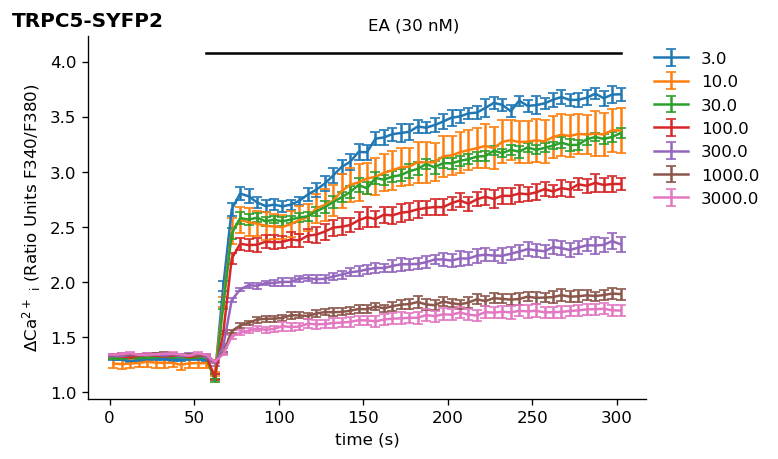

In [46]:
# new plot_conditions code
title = 'TRPC5-SYFP2'
activator = 'EA (30 nM)'
platemap = plate3.plate_map
grouplist = ['Protein','Type', 'Compound','Concentration', 'Concentration Units']
groupdct = {}


for key, val in plate3.processed_data['ratio'].items():
    mapped = platemap.join(val)
    group = mapped[mapped.Valid == True].groupby(grouplist)[val.columns]
    # update dictionary
    groupdct[key] = group
    
# get data, time and error values for each condition
data = groupdct['data'].mean().reset_index()
time = groupdct['time'].mean().reset_index()
yerr = groupdct['data'].sem().reset_index()

# get names of proteins and compounds, excluding control
proteins = data[data['Type'].str.contains('control') == False]['Protein'].unique()
# get number of proteins 
p_len = len(proteins)
for p in range (p_len):
    # get number of compounds for each protein
    compounds = data[(data['Type'].str.contains('control') == False) & (data['Protein'] == proteins[p])]['Compound'].unique()
    c_len = len(compounds)
    for c in range (c_len):
        
        # extract data for each protein and compound, excluding control. 
        data_temp = data[data['Type'].str.contains('control') == False]
        data_temp = data_temp[(data_temp['Protein'] == proteins[p]) & (data_temp['Compound'] == compounds[c])]
        
        time_temp = time[time['Type'].str.contains('control') == False]
        time_temp = time_temp[(time_temp['Protein'] == proteins[p]) & (time_temp['Compound'] == compounds[c])]
        
        yerr_temp = yerr[yerr['Type'].str.contains('control') == False]
        yerr_temp = yerr_temp[(yerr_temp['Protein'] == proteins[p]) & (yerr_temp['Compound'] == compounds[c])]
        
        templist = [x for x in grouplist if x != 'Concentration'] # get columns to remove
        
        # extract just the data with conc as the index
        data_temp = data_temp.set_index('Concentration').drop(templist, axis = 1)
        time_temp = time_temp.set_index('Concentration').drop(templist, axis = 1)
        yerr_temp = yerr_temp.set_index('Concentration').drop(templist, axis = 1)
        
        fig, ax = plt.subplots(dpi = 120)

        # plot series, iterating down rows
        for i in range(len(time_temp)):

            ax.errorbar(x = time_temp.iloc[i], y = data_temp.iloc[i], yerr = yerr_temp.iloc[i],
                       capsize = 3, 
                       label = "{}".format(data_temp.index[i]))
            ax.legend(loc = "upper right", bbox_to_anchor = (1.23, 1.0), frameon = False)
        
        # white background makes the exported figure look a lot nicer
        fig.patch.set_facecolor('white')
        
        # spines
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        # add line representing the activator
        times = plate3.processed_data['ratio']['time'].mean() # get times
        time_filter = times > (plate3.inject - 5) # mean time series that contains activator
        
        # get start and end points
        injection_start = times[time_filter].iloc[0]
        injection_end = times[time_filter].iloc[-1]
        
        # add line indicating presence of activator
        ymax = data_temp.max().max() + data_temp.max().max()*0.1 # add a bit extra to prevent clash w/ data
        ax.plot([injection_start, injection_end], [ymax, ymax], c = 'black')
        
        # activator title
        ax.text((injection_start+injection_end)/2, (ymax+ymax*0.05), activator, ha = 'center')
        
        # assay title
        ax.set_title(title, x = 0, fontweight = '550')
        
        # axes labels
        ax.set_xlabel("time (s)")
        ax.set_ylabel("$\mathrm{\Delta Ca^{2+} \ _i}$ (Ratio Units F340/F380)")

In [9]:
plate3.amplitude('baseline_corrected')

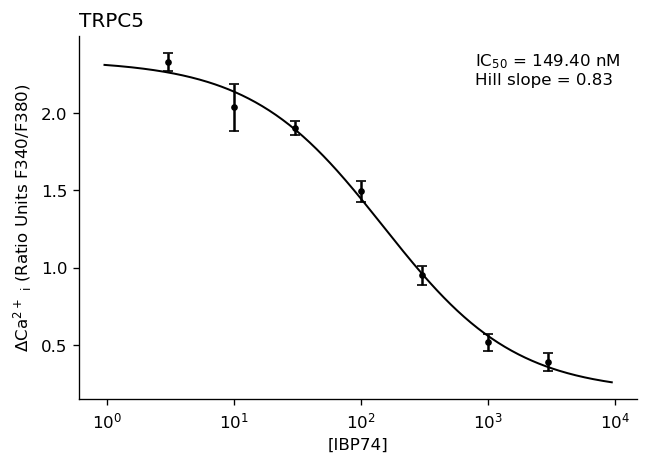

In [11]:
plate3.plot_curve('ic50', title = "TRPC5")